## 로그 변환

비정상 확률 과정으로 모형화 할 수 있는 시계열 자료 중에서 표준편차가 자료의 크기에 비례하여 증가하는 경향을 보이거나 지수함수적으로 증가하는 경향을 보이는 경우에는 로그변환(logarithm transform)을 해야 한다.

우선 표준편차가 자료의 크기에 비례하는 경우를 살펴보자. 추세 함수 즉 기대값이 시간에 따른 함수이고 표준편차는 여기에 비례한다고 하자.

$$\text{E}[Y_t] = \mu_t = f(t)$$

$$\sqrt{\text{Var}[Y_t]} = \mu_t \sigma$$

로그 변환을 하면 다음과 같다.

$$\log Y_t \approx \log \mu_t + \dfrac{Y_t - \mu_t}{\mu_t}$$

$$\text{E}[\log Y_t] = \log \mu_t$$

#### 즉 로그 변환한 결과로 나온 확률 과정의 분산은 일정하게 된다. 따라서 추세 제거를 통해 기댓값을 0으로 만들기만 하면 정상 과정으로 모형화 가능하다

경제 관련 분석에서 흔히 볼 수 있는 수익률 혹은 백분율 자료도 로그 변환과 관련이 있다.

확률 과정  𝑌𝑡 에 대한 백분율 자료  𝑋𝑡 는 다음과 같이 정의된다.

$$X_t = \dfrac{Y_{t}}{Y_{t-1}} - 1$$

여기에서

$$\log{Y_t} - \log{Y_{t-1}} = \log{X_t + 1} \approx X_t \;\; \text{ if } \left| X_t \right| < 0.2$$

이므로 백분률 이나 수익률 자료는 원 자료에 대해 로그 변환을 하고 이를 다시 차분한 것이라 볼 수 있다.

다음 시계열 자료는 항공운송인원 데이터이다.

In [2]:
import matplotlib.pylab as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 12

path = "/Library/Fonts/NanumGothic.otf"
font_name = fm.FontProperties(fname=path, size=20).get_name()

plt.rc('font', family=font_name)

import statsmodels.api as sm
import pandas as pd

In [3]:
data = sm.datasets.get_rdataset("AirPassengers")
df = data.data
df.tail()

time  value
139  1960.583333    606
140  1960.666667    508
141  1960.750000    461
142  1960.833333    390
143  1960.916667    432

In [4]:
def yearfraction2datetime(yearfraction, startyear=0):
    import datetime
    import dateutil
    year = int(yearfraction) + startyear
    month = int(round(12 * (yearfraction - year)))
    delta = dateutil.relativedelta.relativedelta(months=month)
    date = datetime.datetime(year, 1, 1) + delta
    return date

df["datetime"] = df.time.map(yearfraction2datetime)
df.tail()

time  value   datetime
139  1960.583333    606 1960-08-01
140  1960.666667    508 1960-09-01
141  1960.750000    461 1960-10-01
142  1960.833333    390 1960-11-01
143  1960.916667    432 1960-12-01

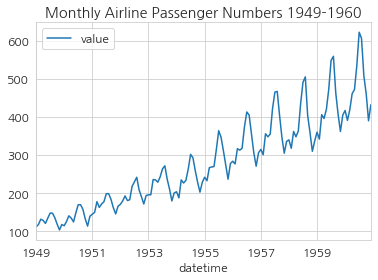

In [6]:
df.plot(x="datetime", y="value")
plt.title(data.title)
plt.show()

값이 상승하며 분산도 증가하고 있음을 볼 수 있다.(즉, 비정상 확률과정이다.) 이 자료를 로그 변환하면 다음과 같다.

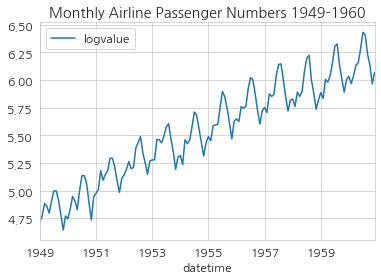

In [7]:
# 1. 분산이 증가하는 비정상 확률과정을 없애기 위해 로그변환 시도
df["logvalue"] = np.log(df.value)
df.plot(x="datetime", y="logvalue")
plt.title(data.title)
plt.show()

여전히 선형 추세는 가지고 있지만 ( E[𝑌𝑡]=𝜇=const. ), 분산의 크기가 비교적 일정하게 변환되었다. 선형 추세를 없애기 위해 이 시계열을 차분한다.

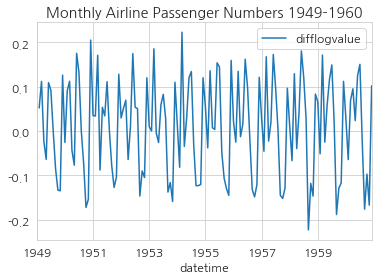

In [9]:
# 2. 선형 추세를 없애기 위해 미분 시도
df["difflogvalue"] = df.logvalue.diff()
df.plot(x="datetime", y="difflogvalue")
plt.title(data.title)
plt.show()

이제 이 데이터는 정상 과정 모형으로 모형화 가능하다.

## Box-Cox 변환

#### Box-Cox 변환은 정규분포가 아닌 자료를 정규분포로 변환하기 위해 사용된다. 모수(parameter)  𝜆 를 가진다.

$$y^{(\boldsymbol{\lambda})} =
\begin{cases}
\dfrac{y^{\lambda} - 1}{\lambda} & \text{if } \lambda \neq 0, \\
\ln{y} & \text{if } \lambda = 0,
\end{cases}$$

보통 여러가지  𝜆  값을 시도하여 가장 정규성을 높여주는 값을 찾아서 사용한다.

위의 사례에 대해 최적의  𝜆 값을 찾기 위해서는 scipy 패키지의 boxcox_normplot 명령과 sp.stats.boxcox 명령을 사용한다. 결과로 구해진 값은 약  𝜆=0.148 이다.

In [12]:
import scipy as sp
import scipy.stats

In [15]:
 # 최적의 람마 값 찾기
x, y = sp.stats.boxcox_normplot(df.value, -2, 2) 
x.shape, y.shape

((80,), (80,))

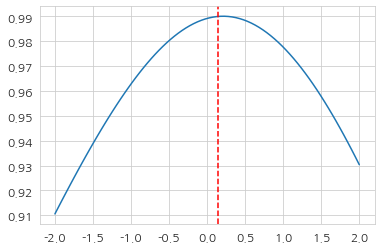

In [19]:
plt.plot(x, y)
y2, l = sp.stats.boxcox(df.value)
plt.axvline(x=l, color='r', ls="--")
plt.show()

In [20]:
print("optimal lambda: ", l)

optimal lambda:  0.14802265137037945


정규성을 비교하기 위해 원자료와 Box-Cox 변환후 차분한 값의 QQ-Plot을 그리면 아래과 같다.

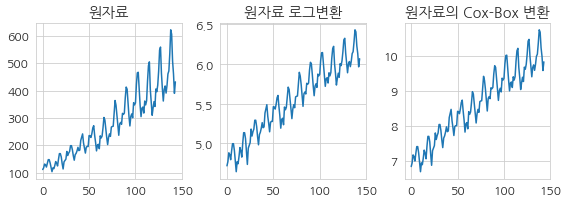

In [23]:
plt.figure(figsize=(8, 3))

plt.subplot(131)
plt.plot(df.value)
plt.title("원자료")

plt.subplot(132)
plt.plot(np.log(df.value))
plt.title("원자료 로그변환")

plt.subplot(133)
plt.plot(y2)
plt.title("원자료의 Cox-Box 변환")

plt.tight_layout()
plt.show()

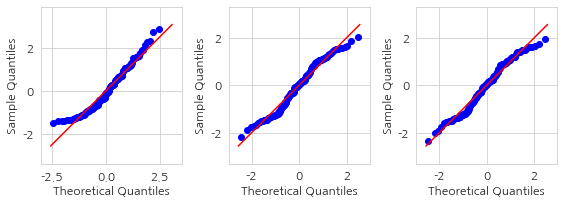

In [25]:
plt.figure(figsize=(8, 3))

ax1 = plt.subplot(131)
sm.qqplot(df.value, fit=True, line="45", ax=ax1)
plt.axis("equal")

ax2 = plt.subplot(132)
sm.qqplot(np.diff(np.log(df.value)), fit=True, line="45", ax=ax2)
plt.axis("equal")

ax3 = plt.subplot(133)
sm.qqplot(np.diff(y2), fit=True, line="45", ax=ax3)  # cox-box 변환된 것을 미분
plt.axis("equal")

plt.tight_layout()
plt.show()